<a href="https://colab.research.google.com/github/SIDIBEMoussa/Hydropower-Climate-Optimisation-Challenge/blob/main/Notebook_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [3]:
! git clone https://github.com/SIDIBEMoussa/Hydropower-Climate-Optimisation-Challenge

Cloning into 'Hydropower-Climate-Optimisation-Challenge'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 39 (delta 14), reused 28 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 4.24 MiB | 11.46 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [4]:
!pip install statsmodels

In [5]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [6]:
path_Data = "/content/Hydropower-Climate-Optimisation-Challenge/Data/Data.csv"

path_subdata = "/content/Hydropower-Climate-Optimisation-Challenge/Data/SampleSubmission.csv"

path_climate_data = "/content/Hydropower-Climate-Optimisation-Challenge/Climate Data/Kalam Climate Data.xlsx"

all_data_df = pd.read_csv(path_Data)
sub_data = pd.read_csv(path_subdata)
climate_data = pd.read_excel(path_climate_data)

In [7]:
len(sub_data),len(all_data_df),len(climate_data)

(6014, 17140913, 12228)

In [8]:
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN


In [9]:
# Split 'Source' into 'consumer_device_X' and 'data_user_Y'
all_data_df[['consumer_device', 'data_user']] = all_data_df['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')

# Display the updated DataFrame (optional)
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device,data_user
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1


In [10]:
sub_data.head()

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0
1,2024-09-25_consumer_device_12_data_user_1,0
2,2024-09-26_consumer_device_12_data_user_1,0
3,2024-09-27_consumer_device_12_data_user_1,0
4,2024-09-28_consumer_device_12_data_user_1,0


In [11]:
climate_data.head()

,Date Time,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
0,2023-06-03 13:00:00,7.199731,-2.448126,-0.034195,0.060989,0.000377,0.0,99.972656
1,2023-06-03 14:00:00,6.000620,-2.597540,-0.080688,0.018585,0.000398,0.0,99.972656
2,2023-06-03 15:00:00,4.789972,-2.696951,0.057449,-0.352020,0.000418,0.0,99.972656
3,2023-06-03 16:00:00,3.158746,-2.879324,0.051529,-0.608948,0.000420,0.0,99.972656
4,2023-06-03 17:00:00,1.671426,-3.255606,0.056137,-0.739838,0.000420,0.0,99.972656


In [12]:
climate_data['Date Time'] = pd.to_datetime(climate_data['Date Time'])
climate_data["Date"] = climate_data['Date Time'].dt.date

climate_data_agg = climate_data.groupby('Date')

# Exclude the 'Date Time' column from the sum operation
climate_data_agg = climate_data_agg.agg({col: 'mean' for col in climate_data.columns if col not in ["Date",'Date Time']})

climate_data_agg.head()

,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
Date,,,,,,,
2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.000414,0.000000e+00,99.972656
2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.001004,0.000000e+00,99.972656
2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.000482,4.858333e-08,99.972656
2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.000371,2.175000e-09,99.972656
2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.000360,0.000000e+00,99.972656


In [13]:
min_date_climate = climate_data['Date Time'].min().date()
max_date_climate = climate_data['Date Time'].max().date()

print(f"Minimum date_time: {min_date_climate}")
print(f"Maximum date_time: {max_date_climate}")

Minimum date_time: 2023-06-03
Maximum date_time: 2024-10-25


In [14]:
# These are the devices that are not in the test SampleSubmission

devices_to_drop = ["consumer_device_3","consumer_device_5","consumer_device_11", "consumer_device_14",
                   "consumer_device_15", "consumer_device_17", "consumer_device_24",
                   "consumer_device_25","consumer_device_27","consumer_device_33","consumer_device_4","consumer_device_9"]

In [15]:
# Filter the DataFrame to include only rows where 'consumer_device' is in the 'devices_to_drop' list.
filtered_df = all_data_df[all_data_df['consumer_device'].isin(devices_to_drop)]

# Now 'filtered_df' contains only the rows you specified.  You can further process or save this DataFrame.
filtered_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device,data_user
327816,2023-10-01 14:35:00,169.26,3.50,0.73,0.036038,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1
327817,2023-10-01 14:40:00,169.20,3.15,0.76,0.033755,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1
327818,2023-10-01 14:45:00,168.38,2.58,0.73,0.026427,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1
327819,2023-10-01 14:50:00,168.87,2.52,0.76,0.026952,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1
327820,2023-10-01 14:55:00,168.30,2.47,0.75,0.025981,consumer_device_11_data_user_1,NaN,NaN,consumer_device_11,1


# Traitement de NaN

In [16]:
filtered_df.isna().sum()*100/len(filtered_df)

,0
date_time,0.000000
v_red,66.311757
current,0.000000
power_factor,0.000000
kwh,0.000000
Source,0.000000
v_blue,66.311757
v_yellow,67.376487
consumer_device,0.000000
data_user,0.000000


In [17]:
filtered_df.describe()

,v_red,current,power_factor,kwh,v_blue,v_yellow
count,2.810596e+06,8.342958e+06,8.342958e+06,8.342958e+06,2.810596e+06,2.721766e+06
mean,1.132487e+01,5.046863e-02,3.277197e-02,4.287172e-04,7.970271e+00,7.846164e+00
std,4.084190e+01,5.204524e-01,1.456608e-01,5.011172e-03,3.339067e+01,3.296655e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.399800e+02,2.940000e+01,9.900000e-01,3.582089e-01,2.222100e+02,2.222100e+02


In [18]:
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device,data_user
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,consumer_device_10,1


In [19]:
all_data_df = all_data_df.fillna(0)

In [20]:
def my_operator(col):
    if col == "kwh":
        return "sum"
    else:
        return "mean"

In [21]:
# for all_data["Source"] aggregate by sum on day

import pandas as pd
# Assuming 'all_data_df' is already defined as in your previous code.
# Convert 'Datetime' column to datetime objects if it's not already
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])

# Extract the date part
all_data_df['Date'] = all_data_df['date_time'].dt.date

# Group by 'Source' and 'Date', then sum the 'Load' for each group
aggregated_data = all_data_df.groupby(['Source', 'Date'])#['kwh'].sum().reset_index()
aggregated_data = aggregated_data.agg({col: my_operator(col) for col in all_data_df.columns if col not in ['Source',"Date",'date_time',"consumer_device","data_user"]}).reset_index()
# Display the aggregated data
aggregated_data.head()


,Source,Date,v_red,current,power_factor,kwh,v_blue,v_yellow
0,consumer_device_10_data_user_1,2024-07-22,99.162941,0.079853,0.384118,0.024330,0.0,0.0
1,consumer_device_10_data_user_1,2024-07-23,101.665556,0.060486,0.342986,0.103560,0.0,0.0
2,consumer_device_10_data_user_1,2024-07-24,100.080938,0.074063,0.399896,0.137543,0.0,0.0
3,consumer_device_10_data_user_1,2024-07-25,101.122604,0.082743,0.356250,0.121011,0.0,0.0
4,consumer_device_10_data_user_1,2024-07-26,32.168472,0.000000,0.000000,0.000000,0.0,0.0


In [24]:
#Join climate to data
final_data = pd.merge(aggregated_data, climate_data_agg, on='Date', how='left')

In [25]:
final_data.head()

,Source,Date,v_red,current,power_factor,kwh,v_blue,v_yellow,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
0,consumer_device_10_data_user_1,2024-07-22,99.162941,0.079853,0.384118,0.024330,0.0,0.0,14.719596,8.280669,0.022655,-0.104998,0.003044,0.0,0.0
1,consumer_device_10_data_user_1,2024-07-23,101.665556,0.060486,0.342986,0.103560,0.0,0.0,13.217268,9.862700,0.116137,-0.077997,0.005080,0.0,0.0
2,consumer_device_10_data_user_1,2024-07-24,100.080938,0.074063,0.399896,0.137543,0.0,0.0,12.462190,9.865658,0.103451,-0.075028,0.004999,0.0,0.0
3,consumer_device_10_data_user_1,2024-07-25,101.122604,0.082743,0.356250,0.121011,0.0,0.0,13.867551,8.973798,0.066345,-0.043182,0.001428,0.0,0.0
4,consumer_device_10_data_user_1,2024-07-26,32.168472,0.000000,0.000000,0.000000,0.0,0.0,15.572609,9.434734,0.093025,0.046414,0.000290,0.0,0.0


In [28]:
final_data.to_csv("/content/Hydropower-Climate-Optimisation-Challenge/JoinData/final_data.csv", index = False)

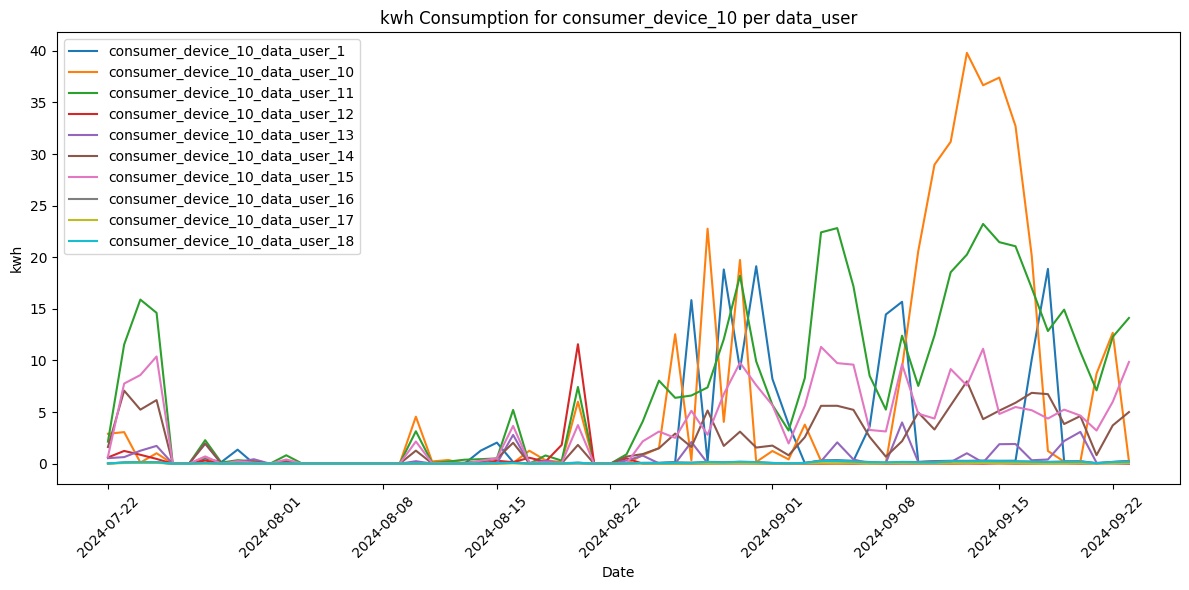

In [30]:
# Filter data for consumer_device_10
aggregated_data = final_data
consumer_10_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_10')]

# Create the plot
plt.figure(figsize=(12, 6))
i = 0
for data_user in consumer_10_data['Source'].unique():
    user_data = consumer_10_data[consumer_10_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)
    i += 1
    if i == 10:
        break

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Find the minimum and maximum date_time values
min_date = aggregated_data['Date'].min()
max_date = aggregated_data['Date'].max()

print(f"Minimum date_time: {min_date}")
print(f"Maximum date_time: {max_date}")

Minimum date_time: 2023-06-24
Maximum date_time: 2024-09-23


In [ ]:
# Fill missing date values with 0 kwh

# Create a date range
date_rng = pd.date_range(start=min_date, end=max_date, freq='D')

# Create an empty DataFrame to store the complete data
complete_data = pd.DataFrame()

# Iterate through each unique 'Source'
for source in aggregated_data['Source'].unique():
    # Extract data for the current 'Source'
    source_data = aggregated_data[aggregated_data['Source'] == source].copy()

    # Convert the source data Date to match the type of date_rng
    source_data['Date'] = pd.to_datetime(source_data['Date'])

    # Create a complete date range for the current 'Source'
    source_date_rng = pd.DataFrame({'Date': date_rng})
    source_date_rng['Source'] = source

    # Merge with the existing data, filling missing 'kwh' values with 0
    source_data = pd.merge(source_date_rng, source_data, on=['Date', 'Source'], how='left')
    source_data['kwh'] = source_data['kwh'].fillna(0)

    # Append to the complete data
    complete_data = pd.concat([complete_data, source_data], ignore_index=True)

In [ ]:
complete_data.head()

,Date,Source,kwh
0,2023-06-24,consumer_device_10_data_user_1,0.0
1,2023-06-25,consumer_device_10_data_user_1,0.0
2,2023-06-26,consumer_device_10_data_user_1,0.0
3,2023-06-27,consumer_device_10_data_user_1,0.0
4,2023-06-28,consumer_device_10_data_user_1,0.0


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Function to process and forecast per unique consumer_device_x and data_user_y
def forecast_arima(all_data, forecast_horizon=30, output_template=None):
    # Convert Date column to datetime format
    all_data['Date'] = pd.to_datetime(all_data['Date'])

    # Extract consumer_device_x and data_user_y
    all_data[['consumer_device', 'data_user']] = all_data['Source'].str.extract(r'consumer_device_(\d+)_data_user_(\d+)')

    # Ensure data is sorted by consumer_device, data_user, and Date
    all_data = all_data.sort_values(by=['consumer_device', 'data_user', 'Date'])

    # Store forecasts
    forecast_results = []

    # Process each unique consumer_device_x and data_user_y combination
    for (consumer_device, data_user), group in all_data.groupby(["consumer_device", "data_user"]):
        # Set Date as index
        group = group.set_index("Date")

        # Ensure data is in the correct format
        group = group.asfreq('D').fillna(method='ffill')  # Fill missing dates with last known value

        # Fit ARIMA model
        try:
            model = ARIMA(group["kwh"], order=(5, 1, 0))  # ARIMA(5,1,0) as a baseline
            fitted_model = model.fit()

            # Forecast for the next forecast_horizon days
            forecast_dates = pd.date_range(start=group.index[-1] + pd.Timedelta(days=1),
                                           periods=forecast_horizon, freq='D')
            forecast_values = fitted_model.forecast(steps=forecast_horizon)

            # Store results in required format
            forecast_df = pd.DataFrame({
                "ID": [f"{date.strftime('%Y-%m-%d')}_consumer_device_{consumer_device}_data_user_{data_user}"
                        for date in forecast_dates],
                "kwh": forecast_values
            })

            forecast_results.append(forecast_df)

        except Exception as e:
            print(f"Error processing {consumer_device}_{data_user}: {e}")

    # Combine all forecasts into a single DataFrame
    forecast_df = pd.concat(forecast_results, ignore_index=True)

    # If an output template is provided, align the output format
    if output_template is not None:
        output_template = output_template.drop(columns=['kwh'], errors='ignore')
        final_output = output_template.merge(forecast_df, on='ID', how='left').fillna(0)
    else:
        final_output = forecast_df

    return final_output


In [ ]:
forecast = forecast_arima(all_data=complete_data, forecast_horizon=30, output_template=sub_data)

In [ ]:
forecast.head()

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.157003
1,2024-09-25_consumer_device_12_data_user_1,0.157044
2,2024-09-26_consumer_device_12_data_user_1,0.206450
3,2024-09-27_consumer_device_12_data_user_1,0.188694
4,2024-09-28_consumer_device_12_data_user_1,0.166484


In [ ]:
# prompt: does forecast["kwh"] contain nans if so replace with 0

# Check for NaN values in the 'kwh' column and replace them with 0
forecast["kwh"] = forecast["kwh"].fillna(0)

In [ ]:
len(complete_data), len(forecast), len(sub_data)

(114958, 6014, 6014)

In [ ]:
forecast.to_csv("forecast.csv", index = False)

In [ ]:
# prompt: list the difference in the ID between forecast and ss

# Assuming 'forecast' and 'ss' DataFrames are already defined as in your provided code.

# Convert 'ID' columns to sets for efficient comparison
forecast_ids = set(forecast['ID'])
ss_ids = set(sub_data['ID'])

# Find IDs present in forecast but not in ss
forecast_only_ids = forecast_ids - ss_ids

# Find IDs present in ss but not in forecast
ss_only_ids = ss_ids - forecast_ids

# Print the IDs that are in forecast but not in ss
print("IDs in 'forecast' but not in 'ss':")
print(forecast_only_ids)


# Print the IDs that are in ss but not in forecast
print("\nIDs in 'ss' but not in 'forecast':")
print(ss_only_ids)

# Print the number of IDs that differ
print(f"\nNumber of IDs that differ: {len(forecast_only_ids) + len(ss_only_ids)}")


IDs in 'forecast' but not in 'ss':
set()

IDs in 'ss' but not in 'forecast':
set()

Number of IDs that differ: 0


In [ ]:
# prompt: compute RMSE score between forecast and ss

import pandas as pd
from sklearn.metrics import mean_squared_error
import math

# Assuming 'forecast' and 'ss' are DataFrames with a common 'ID' column and a 'kwh' column
# containing the forecast and actual values respectively.

# Merge the forecast and ss DataFrames on the 'ID' column
merged_df = pd.merge(forecast, sub_data, on='ID', how='left', suffixes=('_forecast', '_actual'))

# Calculate the RMSE
rmse = math.sqrt(mean_squared_error(merged_df['kwh_actual'], merged_df['kwh_forecast']))

print(f"RMSE: {rmse}")


RMSE: 9.312750604651274


<Axes: >

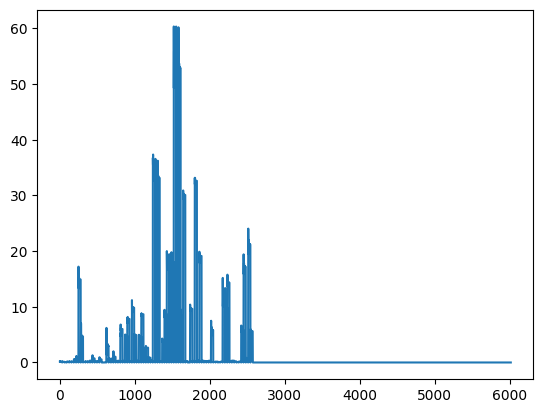

In [ ]:
forecast["kwh"].plot()